### Model Development ###

Up to this point our efforts have been focused on the selection of training pairs or correspondences. These pairs consist of locations of pixels that are in the shade, and associated pixel lists that *may* be the same surface type, but are out in the open. Using the spectral information of the pixels in the open, we develop a model aimed at learning the local radiance attenuation.

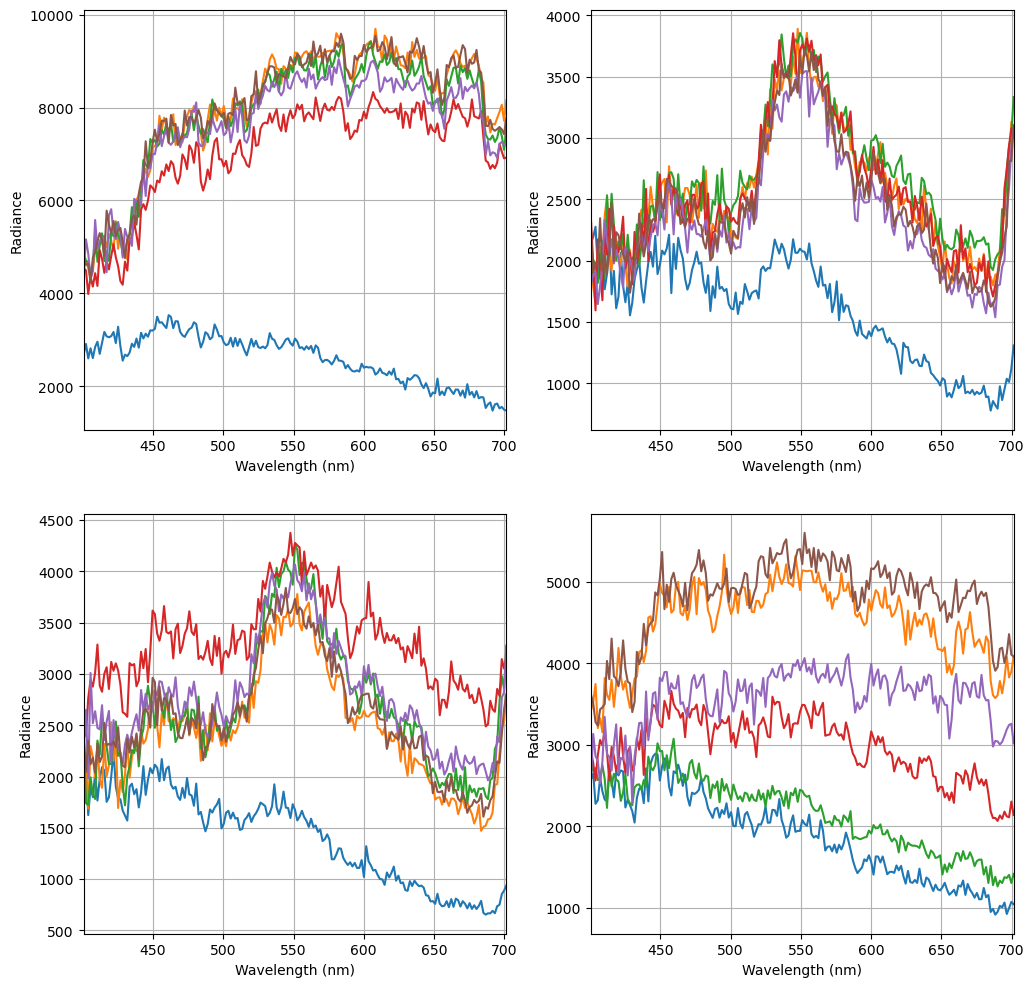

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from hyperspectral import *
import numpy as np
import pickle

correspondences = pickle.load(open('data/training_correspondences.p', 'rb'))

hsi_import = np.load('data/hsi_data.npz')
hsi_data = hsi_import['hyperspectral_data']
wavelengths = hsi_import['wavelengths']


plt.figure(figsize=(12,12))
keys = list(correspondences.keys())
for plot in [ 221, 222, 223, 224 ]:
    key = keys[np.random.randint(0,len(keys))]
    spectra = [ get_spectrum(hsi_data, key) ]
    for px in correspondences[key]:
        spectra.append(get_spectrum(hsi_data, px))

    plt.subplot(plot)
    spectra_plot(wavelengths, np.array(spectra))
plt.show()